# Explore the Analysis Of Record for Calibration (AORC) version 1.1 data
###### Using Xarray, Dask and hvPlot to explore the AORC version 1.1 data. We read from a cloud-optimized Zarr dataset that is part of the NOAA Open Data Dissemination (NODD) program and we use a Dask cluster to parallelize the computation and reading of data chunks.


#### AORC variables available to use:
 - APCP_surface
 - DLWRF_surface
 - DSWRF_surface
 - PRES_surface
 - SPFH_2maboveground
 - TMP_2maboveground
 - UGRD_10maboveground
 - VGRD_10maboveground


***

In [1]:
import xarray as xr
import fsspec
import numpy as np
import s3fs
import zarr

In [2]:
base_url = f's3://noaa-nws-aorc-v1-1-1km'

#### Start a Dask cluster
###### This is not required but it speeds up computations.  Here we start a local cluster that uses the cores available on the computer running the notebook server.  There are many other ways to set up Dask clusters that can scale larger than this.
###### If you are running this on your local machine add this - dask.config.set(temporary_directory='/dask-worker-space') - under import dask

In [3]:
import dask


In [4]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 63.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50023,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 63.70 GiB
Comm: tcp://127.0.0.1:50054,Total threads: 4
Dashboard: http://127.0.0.1:50058/status,Memory: 10.62 GiB
Nanny: tcp://127.0.0.1:50026,


## Load a single year
###### Change the value of the year variable to the specific year

In [5]:
year = '1979'

In [6]:
single_year_url = f'{base_url}/{year}.zarr/'

In [7]:
ds_single = xr.open_zarr(
    single_year_url,
    consolidated=True,
    storage_options={"anon": True}
)

###### Update the variable (var) with the AORC variable.  A full list of available variables are listed at the top of the notebook

In [8]:
var='APCP_surface'

In [9]:
ds_single[var]

<xarray.DataArray 'APCP_surface' (time: 8016, latitude: 4201, longitude: 8401)> Size: 2TB
dask.array<open_dataset-APCP_surface, shape=(8016, 4201, 8401), dtype=float64, chunksize=(144, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 34kB 20.0 20.01 20.02 ... 54.98 54.99 55.0
  * longitude  (longitude) float64 67kB -130.0 -130.0 -130.0 ... -60.01 -60.0
  * time       (time) datetime64[ns] 64kB 1979-02-01 ... 1979-12-31T23:00:00
Attributes:
    AORC_Contact:  aorc.info@noaa.gov
    aorc_version:  v1.1
    crs:           EPSG:4326
    level:         surface
    long_name:     Total Precipitation
    short_name:    APCP_surface
    units:         kg/m^2

In [10]:
print(f'Variable size: {ds_single[var].nbytes/1e12:.1f} TB')

Variable size: 2.3 TB


***

C:\Users\Public\anaconda1\envs\culverts\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: D:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\C88078Awatershed_poly_50m.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


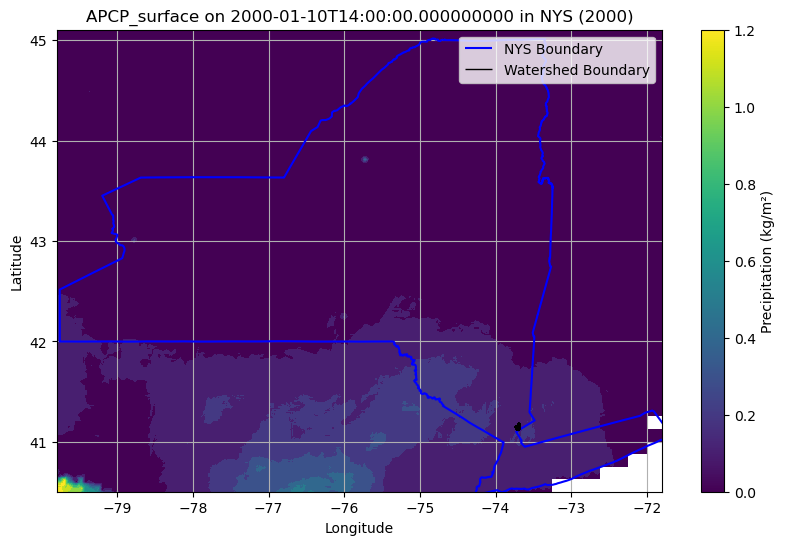

In [17]:
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import geopandas as gpd

# Define the base URL for the dataset
base_url = 's3://noaa-nws-aorc-v1-1-1km'

# Select year and variable for visualization
year = '2000'  # Year of interest
var = 'APCP_surface'  # Variable to plot (e.g., precipitation)

# Create URL for the selected year
single_year_url = f"{base_url}/{year}.zarr/"

# Load the single-year data using xarray and fsspec
ds_single = xr.open_zarr(
    single_year_url,
    consolidated=True,
    storage_options={"anon": True}
)
# Define NYS bounding box (approximate range)
lat_min, lat_max = 40.5, 45.1
lon_min, lon_max = -79.8, -71.8

# Select the first available time point for visualization
time_point = ds_single[var].time[230].values  # First time point

# Subset the data to NYS area using 'latitude' and 'longitude'
ds_nys = ds_single[var].sel(
    time=time_point, 
    latitude=slice(lat_min, lat_max), 
    longitude=slice(lon_min, lon_max)
)

# Load NYS boundary shapefile
nys_boundary_path = r"D:\hydrological analysis\data\initial layers\state_5070.shp"
nys_boundary = gpd.read_file(nys_boundary_path)

# Load the watershed boundary shapefile
watershed_path = r"D:\hydrological analysis\data\waterhsed_delineation_dir\011000060403\C88078Awatershed_poly_50m.shp"
watershed = gpd.read_file(watershed_path)

# Ensure both datasets use the same CRS
dataset_crs = ds_single.rio.crs if ds_single.rio.crs else None
if dataset_crs and (nys_boundary.crs != dataset_crs or watershed.crs != dataset_crs):
    nys_boundary = nys_boundary.to_crs(dataset_crs)
    watershed = watershed.to_crs(dataset_crs)

# Plot the selected variable within the NYS region
fig, ax = plt.subplots(figsize=(10, 6))

# Plot precipitation data
ds_nys.plot(ax=ax, cmap='viridis', add_colorbar=True, cbar_kwargs={'label': 'Precipitation (kg/m²)'})  # Add color bar

# Overlay the NYS boundary
nys_boundary.boundary.plot(ax=ax, color="blue", linewidth=1.5, label='NYS Boundary')  # NYS boundary in blue

# Overlay the watershed boundary
watershed.boundary.plot(ax=ax, color="black", linewidth=1, label='Watershed Boundary')  # Watershed boundary in black

# Add titles and labels
plt.title(f"{var} on {time_point} in NYS ({year})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid()
plt.legend()  # Show legend
plt.show()


In [14]:
ds_nys

<xarray.DataArray 'APCP_surface' (latitude: 612, longitude: 936)> Size: 5MB
dask.array<getitem, shape=(612, 936), dtype=float64, chunksize=(128, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 5kB 40.01 40.02 40.02 ... 45.08 45.09 45.1
  * longitude  (longitude) float64 7kB -79.79 -79.79 -79.78 ... -72.01 -72.0
    time       datetime64[ns] 8B 2000-01-10T14:00:00
Attributes:
    AORC_Contact:  aorc.info@noaa.gov
    aorc_version:  v1.1
    crs:           EPSG:4326
    level:         surface
    long_name:     Total Precipitation
    short_name:    APCP_surface
    units:         kg/m^2

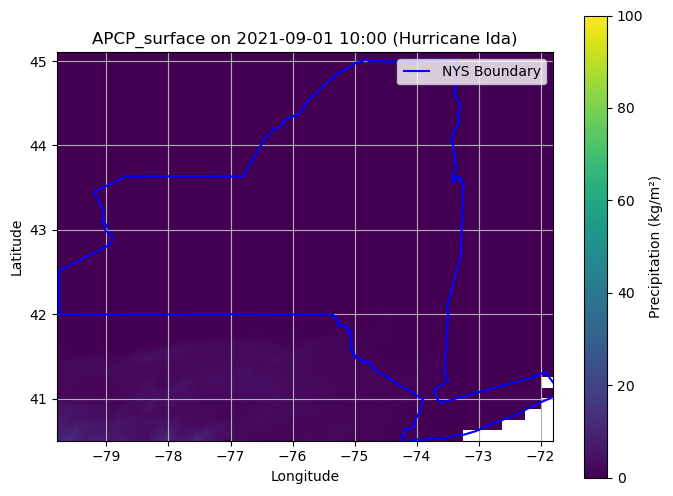

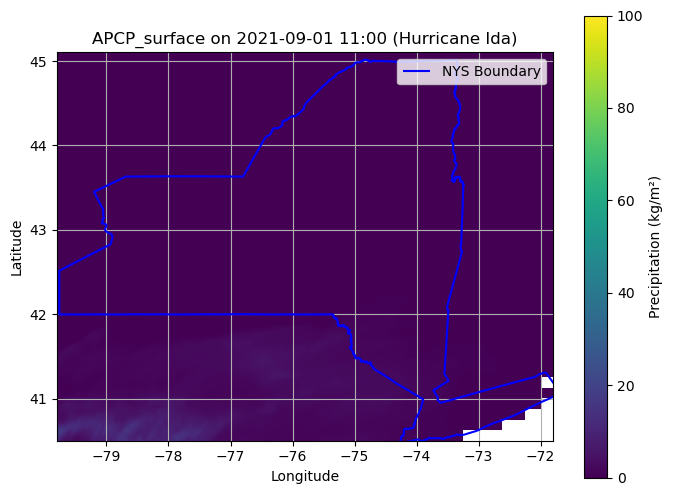

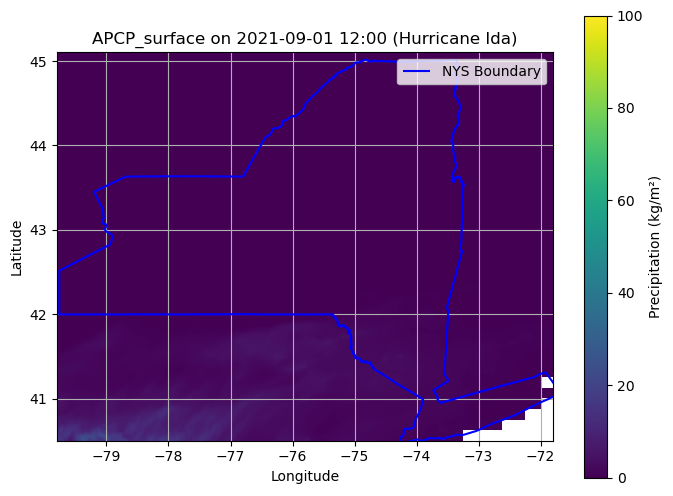

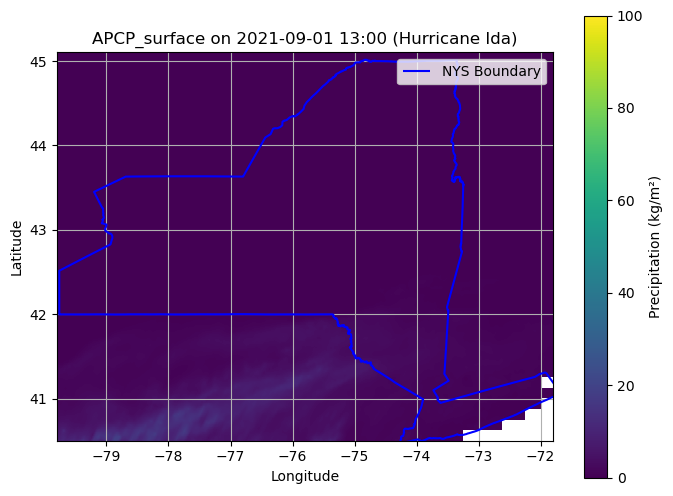

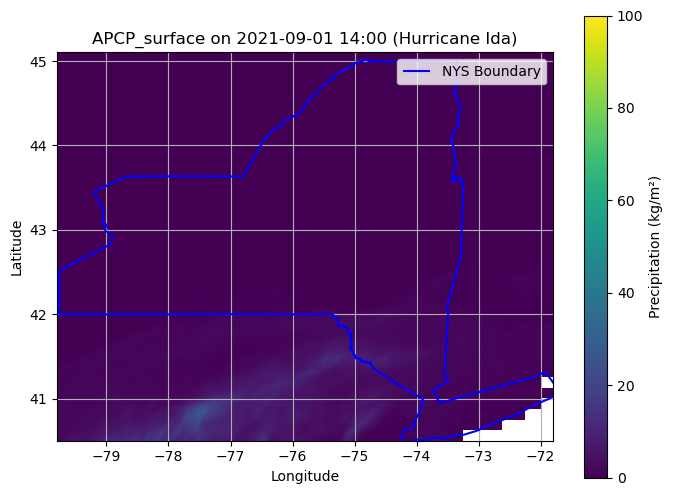

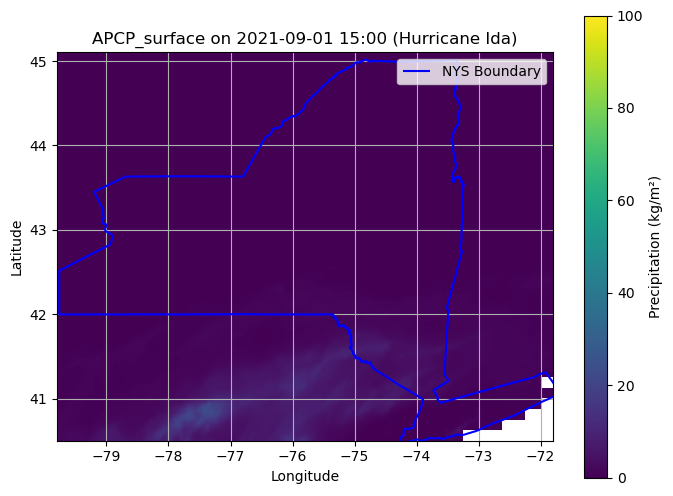

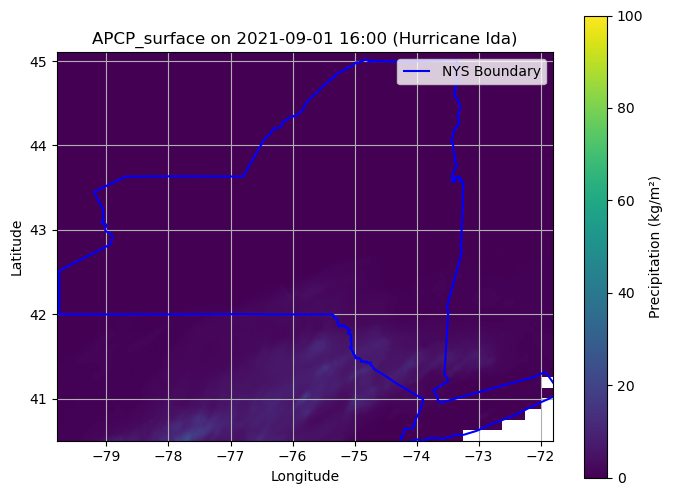

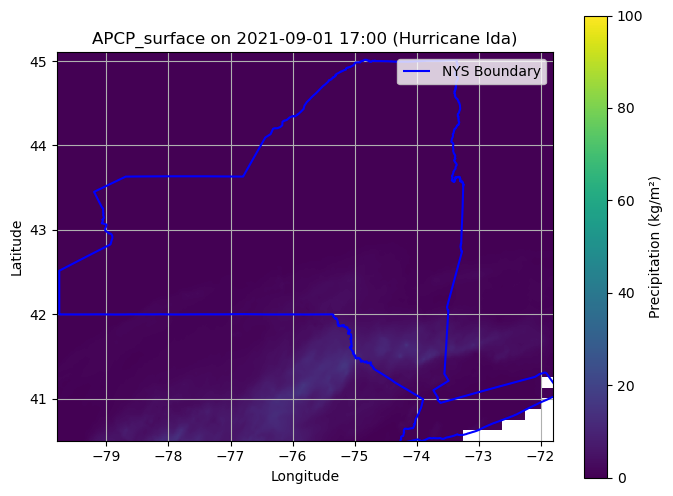

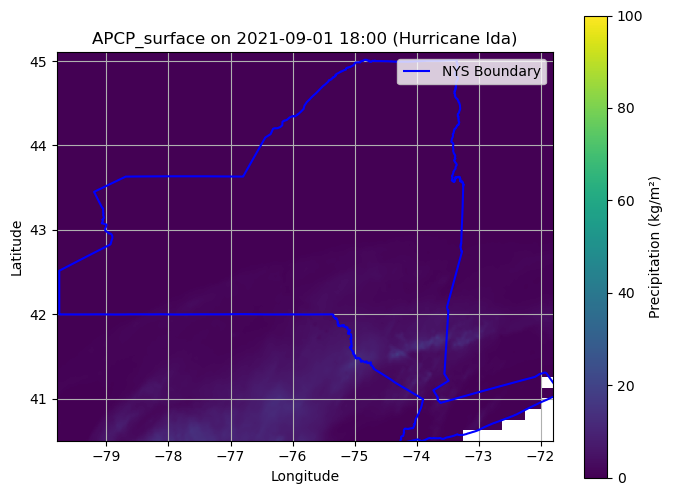

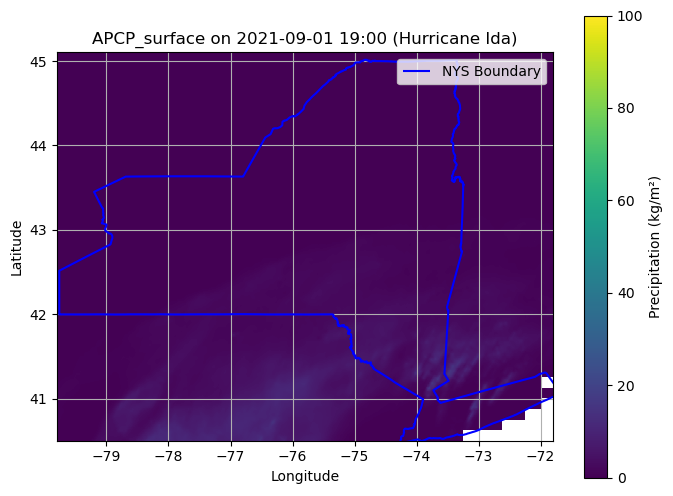

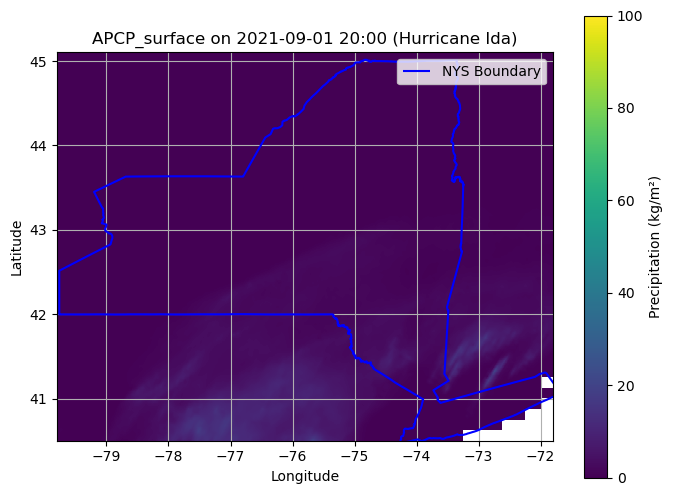

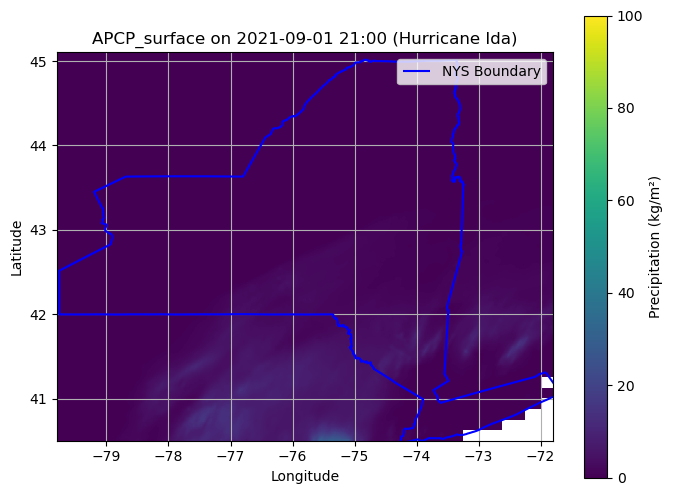

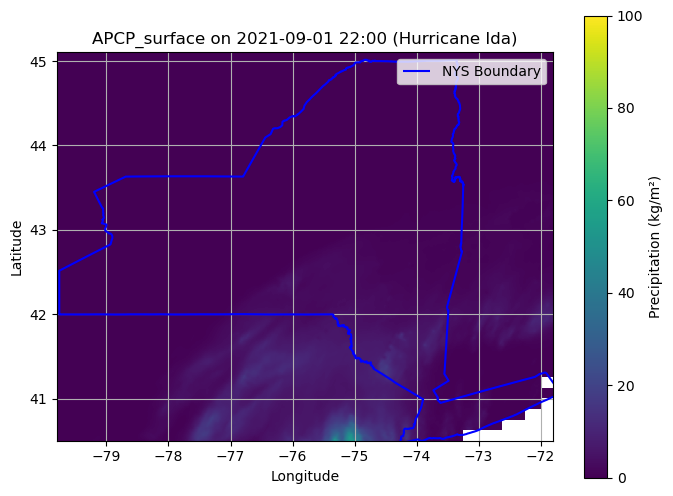

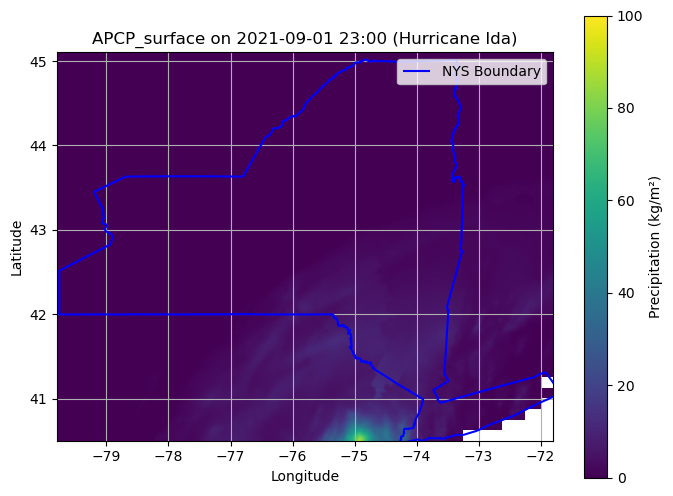

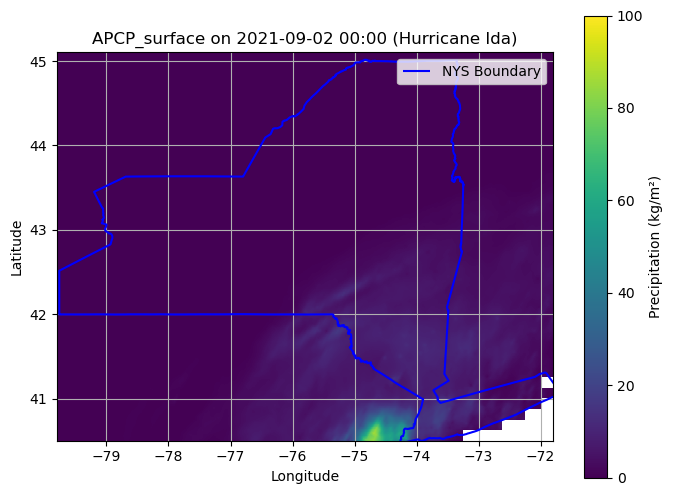

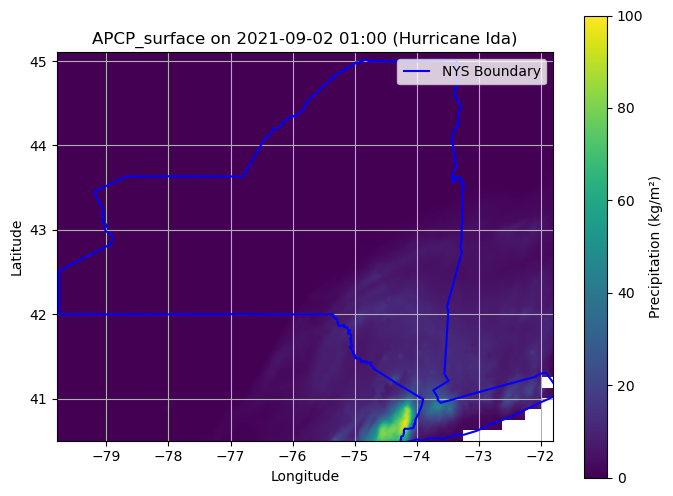

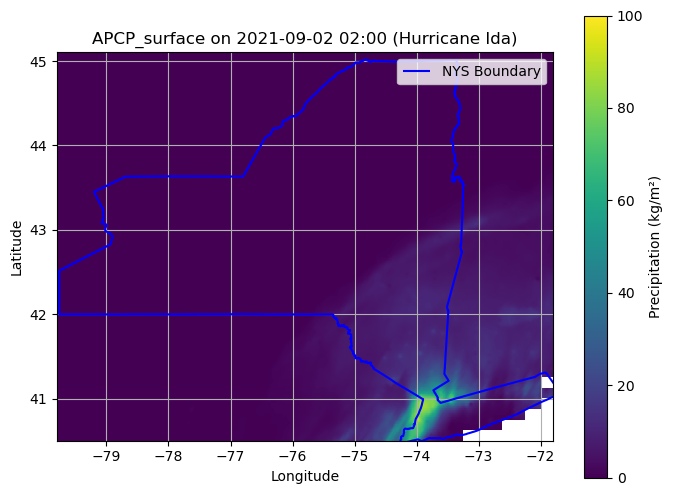

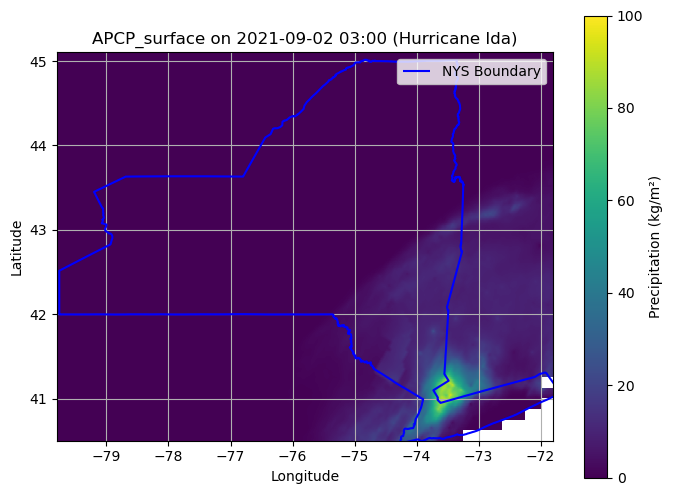

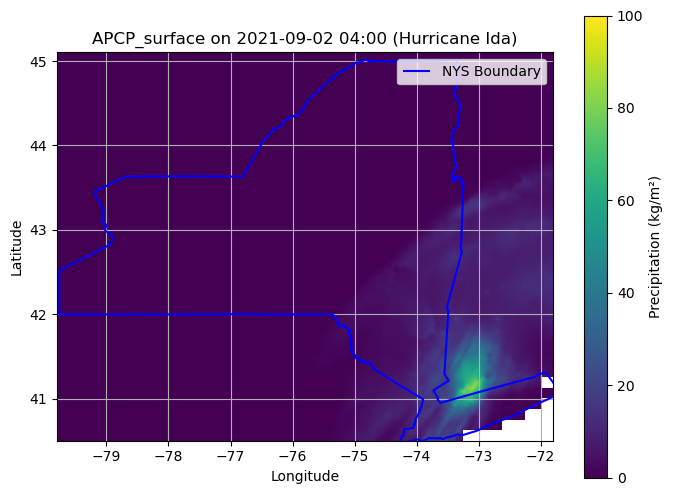

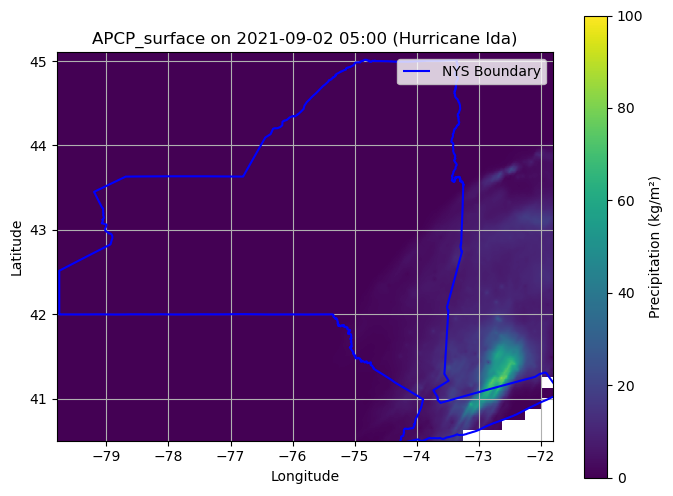

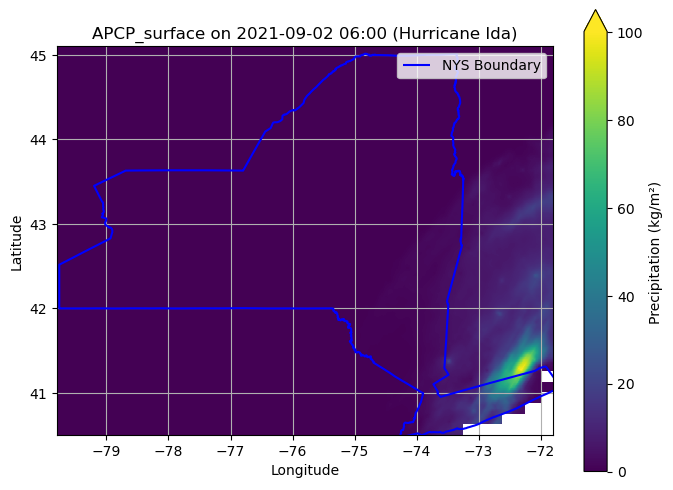

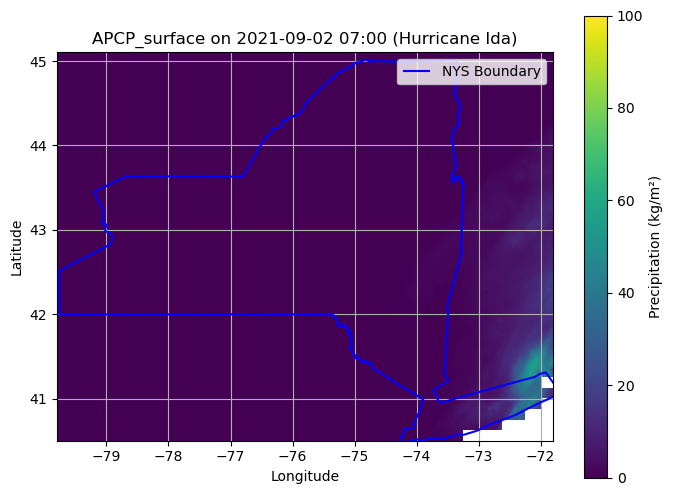

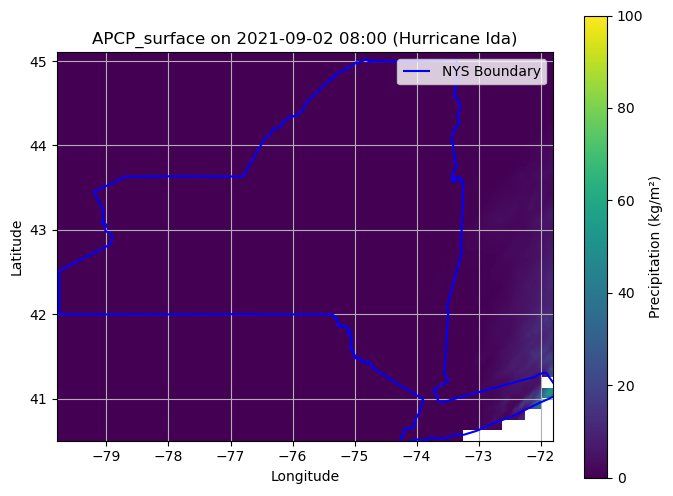

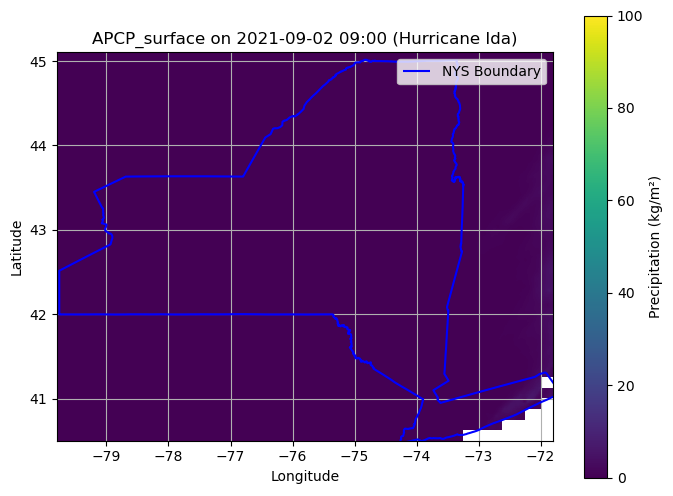

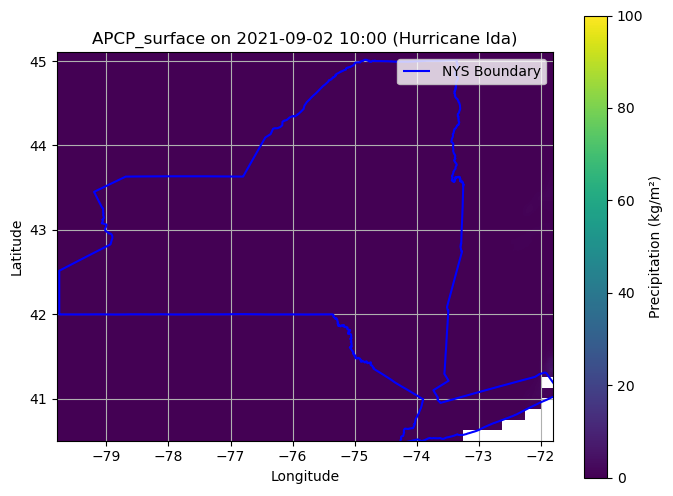

['D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1000.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1100.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1200.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1300.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1400.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1500.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1600.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1700.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1800.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 1900.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 2000.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 2100.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_2021-09-01 2200.png',
 'D:\\AORC_NYS_Subsets\\Ida_Maps\\APCP_surface_Ida_

In [20]:
import xarray as xr
import fsspec
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os

# Define the base URL for the dataset
base_url = 's3://noaa-nws-aorc-v1-1-1km'

# Year and variable of interest
year = '2021'
var = 'APCP_surface'

# Define NYS bounding box
lat_min, lat_max = 40.5, 45.1
lon_min, lon_max = -79.8, -71.8

# Define time range during Hurricane Ida's impact in NY (approx.)
start_time = pd.to_datetime("2021-09-01 10:00")
end_time = pd.to_datetime("2021-09-02 10:00")

# Load NYS boundary
nys_boundary_path = r"D:\hydrological analysis\data\initial layers\state_5070.shp"
nys_boundary = gpd.read_file(nys_boundary_path)

# Open Zarr dataset
ds = xr.open_zarr(
    f"{base_url}/{year}.zarr/",
    consolidated=True,
    storage_options={"anon": True}
)

# Select time range and bounding box
time_slice = ds.sel(time=slice(start_time, end_time))
precip_data = time_slice[var].sel(
    latitude=slice(lat_min, lat_max),
    longitude=slice(lon_min, lon_max)
)

# Match CRS if needed
if hasattr(ds, "rio") and ds.rio.crs:
    target_crs = ds.rio.crs
    if nys_boundary.crs != target_crs:
        nys_boundary = nys_boundary.to_crs(target_crs)

# Generate one plot per time step
output_dir = r"D:\AORC_NYS_Subsets\Ida_Maps"
os.makedirs(output_dir, exist_ok=True)

timestamps = precip_data.time.values[:34]  # First few time slices to demo
plot_paths = []

for t in timestamps:
    data_t = precip_data.sel(time=t)

    fig, ax = plt.subplots(figsize=(8, 6))
    data_t.plot(ax=ax, cmap='viridis', cbar_kwargs={'label': 'Precipitation (kg/m²)'},vmax=100)
    nys_boundary.boundary.plot(ax=ax, color="blue", linewidth=1.5, label='NYS Boundary')

    ts_str = pd.to_datetime(t).strftime('%Y-%m-%d %H:%M')
    ax.set_title(f"{var} on {ts_str} (Hurricane Ida)")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)
    ax.legend()
    file_path = os.path.join(output_dir, f"{var}_Ida_{ts_str.replace(':','')}.png")
    plt.savefig(file_path)
    plt.show()
    plt.close(fig)
    plot_paths.append(file_path)

plot_paths

In [18]:
import xarray as xr
import fsspec
import os
import pandas as pd
from tqdm import tqdm

# AOI: New York State bounding box
lat_min, lat_max = 40, 45.1
lon_min, lon_max = -79.8, -72

# Variable to subset
var = 'APCP_surface'

# Output directory
output_dir = r"D:\AORC_NYS_Subsets\Hourly"
os.makedirs(output_dir, exist_ok=True)

# List of years to process
years = list(map(str, range(1979, 2024)))

for year in years:
    print(f"\n🔄 Processing year {year}...")
    try:
        # Load AORC Zarr dataset from S3
        url = f's3://noaa-nws-aorc-v1-1-1km/{year}.zarr'
        ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})

        # Subset spatial area
        ds_var = ds[var].sel(
            latitude=slice(lat_min, lat_max),
            longitude=slice(lon_min, lon_max)
        )

        # Iterate through each hourly time step with progress bar
        for time_val in tqdm(ds_var.time.values, desc=f"⏳ Saving {year}", unit="hr"):
            hourly_slice = ds_var.sel(time=time_val).to_dataset(name=var)

            # Format timestamp for filename
            timestamp_str = pd.to_datetime(time_val).strftime('%Y%m%d_%H%M')
            output_path = os.path.join(output_dir, f"{var}_{year}_{timestamp_str}.nc")

            # Save each time slice
            hourly_slice.to_netcdf(
                output_path,
                engine="netcdf4",
                encoding={var: {"zlib": True, "complevel": 4}}
            )

    except Exception as e:
        print(f"❌ Failed to process year {year}: {e}")



🔄 Processing year 2023...


⏳ Saving 2023:   1%|▍                                                             | 56/8760 [01:53<4:54:10,  2.03s/hr]


KeyboardInterrupt: 

In [30]:
from joblib import Parallel, delayed
import multiprocessing
import xarray as xr
import fsspec
import os
import pandas as pd
from tqdm import tqdm
def process_single_year(year):

    # AOI: New York State bounding box
    lat_min, lat_max = 40, 45.25
    lon_min, lon_max = -79.75, -72

    var = 'APCP_surface'
    output_dir = r"D:\AORC_NYS_Subsets\Hourly"
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n🔄 Processing year {year}...")
    try:
        url = f's3://noaa-nws-aorc-v1-1-1km/{year}.zarr'
        ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})
        ds_var = ds[var].sel(
            latitude=slice(lat_min, lat_max),
            longitude=slice(lon_min, lon_max)
        )

        for time_val in tqdm(ds_var.time.values, desc=f"⏳ Saving {year}", unit="hr"):
            hourly_slice = ds_var.sel(time=time_val).to_dataset(name=var)
            timestamp_str = pd.to_datetime(time_val).strftime('%Y%m%d_%H%M')
            output_path = os.path.join(output_dir, f"{var}_{year}_{timestamp_str}.nc")
            hourly_slice.to_netcdf(
                output_path,
                engine="netcdf4",
                encoding={var: {"zlib": True, "complevel": 6, "shuffle": True}}
            )

    except Exception as e:
        print(f"❌ Failed to process year {year}: {e}")

# List of years to process
years = list(map(str, range(1979, 2015)))  # Update range as needed

if __name__ == "__main__":
    n_jobs = multiprocessing.cpu_count()
    Parallel(n_jobs=n_jobs)(delayed(process_single_year)(year) for year in years)
